# High Order Linear Multistep Preconditioners

## Interpretaion of preconditioners in SDC
In SDC, the interpretation of the preconditioner can become quite obscure when looking only at the simplified derivation of SDC as shown for instance in the [pySDC paper](https://doi.org/10.1145/3310410).
Here, SDC is derived in four steps to solve the initial value problem $\partial_t u=F(t, u)$, $u(0)=u_0$:
 - Integrate both sides of the initial value problem with respect to time
 - Discretize with a quadrature rule
 - Form Picard iteration
 - Precondition the system

Finally, one arrives at this formula for performing a sweep:
$$(I - \Delta t Q_\Delta)(u^{k+1}) = u_0 + \Delta t(Q-Q_\Delta)F(u^k),$$
where $k$ is the iteration index, $Q$ realizes the quadrature rule and $Q_\Delta$ is the preconditioner.

It becomes perfectly obvious that a lower triangular $Q_\Delta$ is useful, such that we can solve the system with forward substitution and it is clear how to implement this from this equation, but since the preconditioner appears on both sides, it is difficult to interpret.
Why would implicit Euler be a good preconditioner for this system?
What are we actually integrating with implicit Euler here?

To understand this, it makes sense to go through the [original derivation](https://doi.org/10.1023/A:1022338906936) of SDC from Dutt et al.
We do not need to understand all the nuances, but the crucial point is that the update between sweeps is
$$u^{k+1} = u^{k} + \delta^{k+1},$$
where $\delta^k$ is the error of iteration $k$.
This is the "deferred correction" part in spectral deferred corrections.
Instead of solving the original equation, we are solving an equation for the error and adding correction terms to the approximate solution to make it more accurate.

In section 2.1, of the Dutt et al. paper, are the crucial steps outlining how to arrive at the equation for the error.
We only present the result here:
$$\delta^{k+1}(t) - \int_0^t\left(F(\tau, u^k(\tau) + \delta^{k+1}(\tau)) - F(\tau, u^{k}(\tau))\right) d\tau = r^k(t),\\
r^k(t) = u_0 + \int_0^t F(\tau, u^k(\tau))d\tau - u^k(t)$$
where $r^k$ is the residual after $k$ iterations.

The next step is to descretize the integrals with quadrature rules.
Since the residual only depends on the iteration that we already know, we do not need to solve any system but just evaluate the right hand side at the quadrature nodes.
While this is, of course, also not computationally free, evaluating this with very high accuracy is crucial to solving the equation for the error accurately, so we do this with the full, dense quadrature rule $Q$.

Now for solving the error equation at $t=\Delta t$, we get a system of equations that requires solving and this is precisely where we put in the preconditioner $Q_\Delta$ as a simplified quadrature rule that is easier to apply.
The resulting system is:
$$\delta^{k+1} = r^k + \Delta t Q_\Delta(F(u^k + \delta^{k+1}) - F(u^k)),\\
r^k = u_0 + \Delta t QF(u^k) - u^k.$$

Now let's plug this into the update formula where we add the corrections:
$$u^{k+1} = u^{k} + \delta^{k+1} = u^{k} + u_0 + \Delta t QF(u^k) - u^k + \Delta t Q_\Delta(F(u^k + \delta^{k+1}) - F(u^k)).$$
We see that the $u^k$ on the right hand side cancel, and we plug in the update formula on the right to replace the argument of $F(\Delta t, u^k + \delta^{k+1})$ with $F(\Delta t, u^{k+1}).$
We end up with
$$u^{k+1} = u_0 + \Delta t QF(u^k) + \Delta t Q_\Delta(F(u^{k+1}) - F(u^k)),$$
which becomes exactly the formula from the simple derivation if we move both $u^{k+1}$ terms to the left hand side.

Following these extra steps makes clear that we are still solving an equation for the defect with the preconditioner and then correcting the solution with the computed defect, even though it becomes obscure in the final equation.
Another fact becomes apparent: The accuracy of computing the corrections is limited by how well we can compute the residual, which, in turn, depends on the accuracy of the full quadrature rule.

One final thing we need to mention is that the full quadrature rules are build on stages, like a Runge-Kutta system.
That means we compute the solution at multiple intermediate time points.
An SDC sweep with a preconditioner which is lower triangular (which we require to solve the system with forward substitution), will then proceed to successively compute approximations at each of the time points like a time stepping scheme within the time step.
This can be whatever time stepping scheme you like!
Implicit Euler is well liked for its stability properties, but other (higher order) choices are also possible.
Linear multistep methods allow to get higher order and we will show some of their properties for SDC here.
As a side note: Interpretation of the preconditioner as a time stepping scheme is not required.
In fact, the LU preconditioner, which is algebraically motivated, is a very popular choice.

## Constructing linear multistep methods (LMMs)
LMMs are based on Taylor expanding the solution in time and then summing solutions and right hand side evaluations at different steps to cancel as many terms in the Taylor expansion.
The Taylor expansion of the solution at time $t$, which we want to solve for is
$$u(t-h) = \sum^{p}_{i=0}\frac{(-h)^i}{i!}\partial_t^i u(t) = \mathcal{O}(h^{p+1}).$$
Since we want to compute $u(t)$, we want to cancel all other terms in the Taylor expansion.

The solutions at previous steps share the same expansion, but the right hand side evaluations are missing the solution and a power of the step size.
Their expansion is
$$f(t-h) = \sum^p_{i=1}\frac{(-h)^{(i-1)}}{(i-1)!}\partial_t^{i}u(t) + \mathcal{O}(h^{p+1}).$$

The linear multistep method will then look like
$$u(t) = \sum_{i=0}^p \left(\alpha_i u(t-h_i) + \beta_i f\left(u\left(t-h_i\right), t-h_i\right)\right),$$
and we need to choose $\alpha_i$ and $\beta_i$ in a way that suits us and that cancels the most possible terms in the Taylor expansion.

What suits us best is mainly determined by what we have available, which is, in the pySDC implementation, the initial conditions and the right hand side evaluations at all the nodes.
That means with $h_i$ the time differences to where we want to solve for in descending order: $\alpha_0=1$ and $\beta_i \neq 0$.
In particular, $\beta_p\neq 0$, to make the scheme implicit.

In order to cancel as many terms as we can, we setup a linear system of equations that carries the coefficients of the Taylor expansion.
We construct a matrix $A$ with
$$A_{ij} = \cases{(-h_i)^j / j!, & j = 0\\
                  (-h_i)^{(j-1)} / (j-1)!, & i,j > 0}.$$
We will then proceed to solve a system $Ax=b$, which means we need a vector $b$ on the right hand side.
Since we want to solve for the solution at time $t$ itself and want to cancel all other terms, we need a one in the first entry, corresponding to $u(t)$ and zeros everywhere else:
$$b = \delta_{i0}.$$

Conveniently for us, $u(t-h_0)$ is the only term carrying $u(t)$ in its expansion, and since we want a one in the corresponding row of the solution, we will always get $\alpha_0=1$, which means we don't have to modify the implementaion of pySDC in the sweeps.
The remaining coefficients make up a single row of the preconditioner and are the $\beta_i$ coefficients that will be multiplied to the right hand side evaluations in the sweeps.

Crucially, we increase the order of the LMM by one in each row of the preconditioner.
In the first row, we get the trapezoidal rule (or implicit Euler, if we set $\beta_0=0$), and then we gain an order in the expansions with each row.

Let's look at this in practice:
## Numerical experiments

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pySDC.projects.Resilience.accuracy_check import plot_all_errors, plot_orders
from pySDC.projects.Resilience.vdp import run_vdp
from pySDC.projects.Resilience.advection import run_advection
from pySDC.projects.Resilience.piline import run_piline
from pySDC.playgrounds.Preconditioners.heat import run_heat
from pySDC.playgrounds.Preconditioners.dahlquist import run_dahlquist, plot_stability

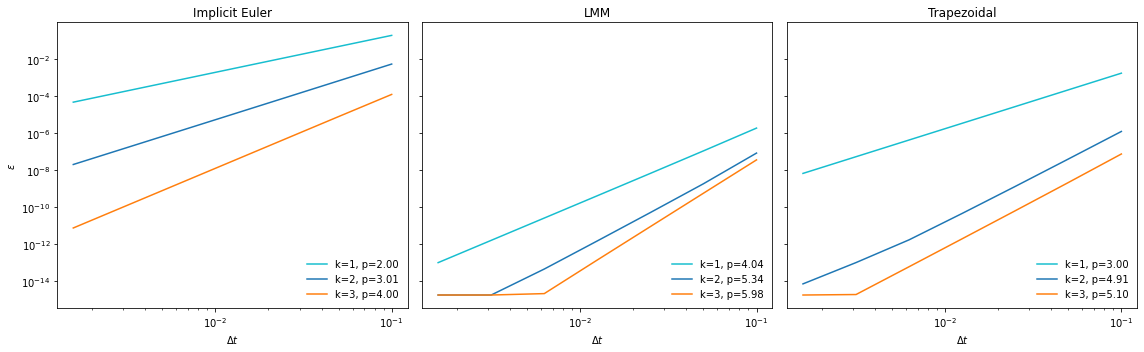

In [2]:
num_nodes = 3
IE_desc = {'sweeper_params': {'QI': 'IE', 'num_nodes': num_nodes}}
Taylor_desc = {'sweeper_params': {'QI': 'LMM', 'num_nodes': num_nodes}}
trap_desc = {'sweeper_params': {'QI': 'TRAP', 'num_nodes': num_nodes}}
ks = [1, 2, 3]

def compare_preconditioners(prob, dt_list, ks, Tend_fixed):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
    descriptions = [IE_desc, Taylor_desc, trap_desc]
    titles = ['Implicit Euler', 'LMM', 'Trapezoidal']
    for i in range(len(descriptions)):
        plot_orders(axs[i], ks, True, Tend_fixed=Tend_fixed, custom_description=descriptions[i], dt_list=dt_list, prob=prob)
        axs[i].set_title(titles[i])
        if i > 0:
            axs[i].set_ylabel('')

    fig.tight_layout()


Tend = 0.1
compare_preconditioners(run_piline, Tend * 2.**(-np.arange(7)), ks, Tend)

What you see above is the order for the pi-line problem, a non-linear ordinary differential equation, which we integrate with an IMEX scheme such that we only need to solve linear systems in each step.
$k$ is the number of sweeps and $p$ is the order of the scheme.

Each of the panels shows a different time marching scheme for the preconditioner and we see the expected $p=k+1$ for implicit Euler.
For the trapezoidal rule, we increase the order of accuracy by two with each sweep, which is what we expected, but at the third sweep we stay at order 5 instead of the maximal possible order 6, for some reason.
The LMM, on the other hand, gives us a thrid order accurate method in the first sweep, but then the order rises only by one with each sweep.
This behaviour is slightly odd, but maybe this is just down to numerics.

This looks nice! We did no extra work and yet we got a higher order method!

Now let's try a partial differential equation:

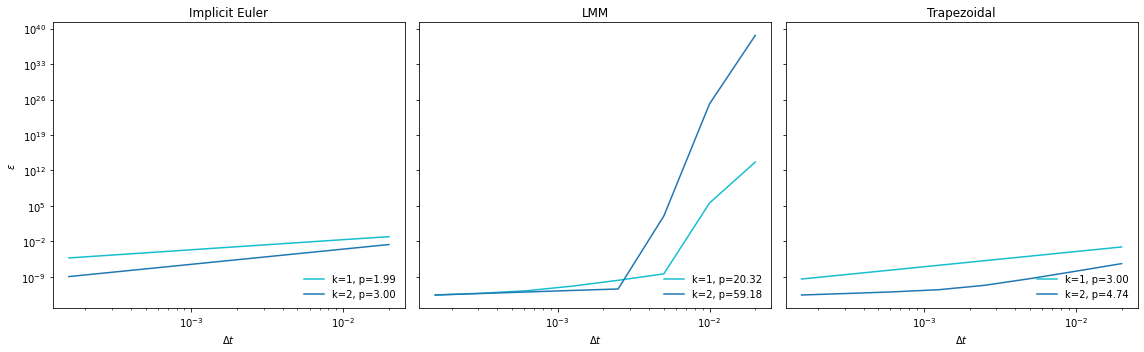

In [3]:
Tend = 2e-2
compare_preconditioners(run_advection, Tend * 2.**(-np.arange(8)), [1, 2], None)

Cowabanga! Looks like we need to talk stability...

## Stability of the preconditioners
The standart tool for analysing LMMs are the characteristic polynomials.
Since the only coefficient for $u$ is one for the initial conditions (but on the right hand side), we get a first characteristic polynomial
$$\rho(r) = r^p - 1.$$

Now, first of all, we need to make sure that our method is convergent, by showing that it is consistent and zero stable.
Showing that a scheme is consistent usually works by computing the linear difference operator and Taylor expanding all the terms to make sure everything cancels up to the order of consistency.
Since that is exactly how we derived the scheme, it is consistent to the order of the number of collocation nodes by default.

To show zero stability, we need to make sure that the roots of the first characteristic polynomial are all smaller or equal to one and that they are distinct.
In that case, the solution will stay bounded when applied to the test problem $\partial_t u = 0$.
Since our first characteristic polynomial is particularly simple, we can immediately see that the roots $r = 1^{1/p}$ are all bounded by one and destinct.

So we have a consistent and zero stable method, which is hence convergent by Dahlquists theorem.
But is it A-stable?
Dahlquist, who was very helpful with his theorems up to now, will crush our dreams at this point with his second barrier theorem, which states that there is no A-stable LMM with order greater than 2.
Wanting to improve on the trapezoidal rule, it is at this point that we realize that we can't.

We can numerically determine the region of absolute stability of a preconditioner by just running many Dahlquist problems and checking if the solution grows or not.

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/numpy/ma/core.py:2825: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


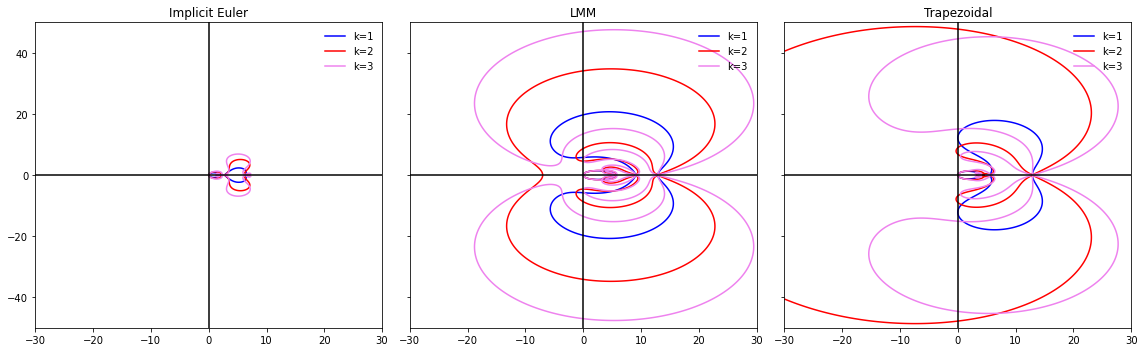

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
descriptions = [IE_desc, Taylor_desc, trap_desc]
titles = ['Implicit Euler', 'LMM', 'Trapezoidal']
for i in range(len(descriptions)):
    axs[i].set_title(titles[i])
    stats, _, _ = run_dahlquist(custom_description=descriptions[i])
    plot_stability(stats, ax=axs[i], iter=ks)

fig.tight_layout()

The above experiments shows why implicit Euler is such a popular preconditioner for SDC.
Yes, it's only first order, but also yes, it is stable.
The trapezoidal rule, which is also A-stable, turns out to become only conditionally stable when we perform multiple iterations.
The LMM, actually shows rather good stability properties for a single sweep, but the region of stability quickly diminishes when we perform more iterations.

We can see what happens we take a different amount of nodes:

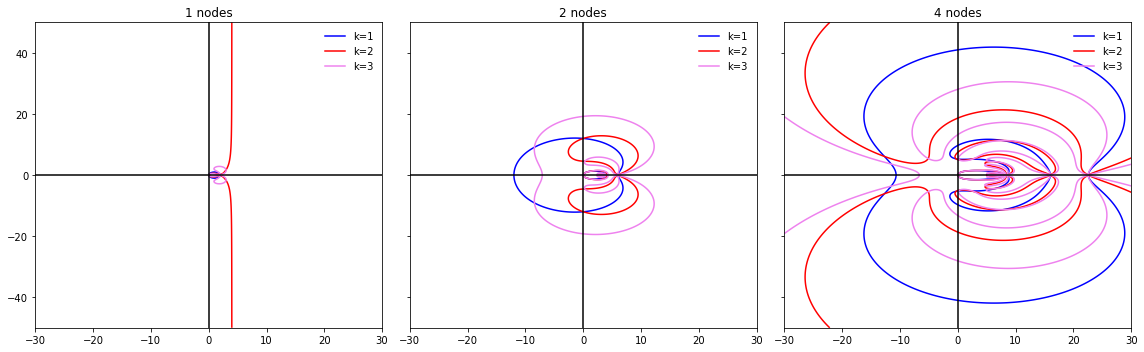

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
nodes = [1, 2, 4]
for i in range(len(nodes)):
    desc = {'sweeper_params': {'QI': 'LMM', 'num_nodes': nodes[i]}}
    axs[i].set_title(f'{nodes[i]} nodes')
    stats, _, _ = run_dahlquist(custom_description=desc)
    plot_stability(stats, ax=axs[i], iter=ks)

fig.tight_layout()

When we use only one node, we have an A-stable method!
But recall that we get just the trapezoidal rule here and the quadrature rule is very low order so we don't get very far with this!

Two nodes actually shows very restricted stability at the first sweep, so that's not helpful.
Four nodes is a bit better than 2, but also very severe restrictions on stability.
So it seems that we found a sweet spot with three nodes.

What about different quadrature rules?

sweeper - WARNING: we need to do a collocation update here, since the right end point is not a node. Changing this!


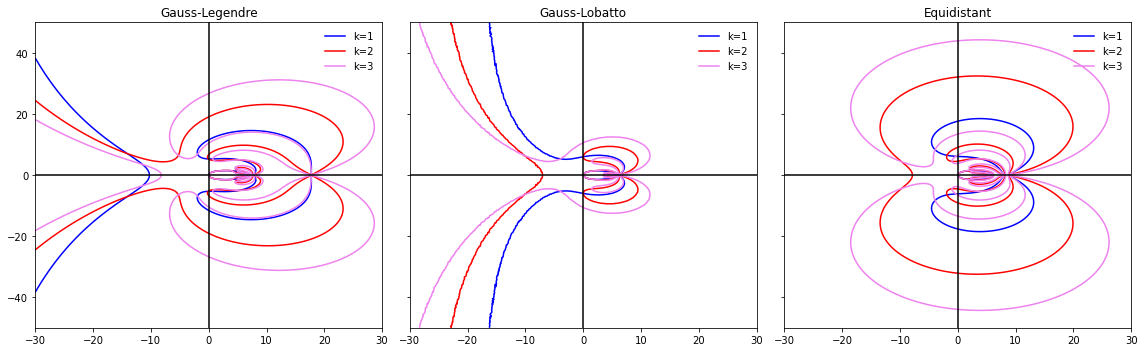

In [6]:
from pySDC.implementations.collocation_classes.gauss_legendre import CollGaussLegendre
from pySDC.implementations.collocation_classes.equidistant_right import EquidistantNoLeft
from pySDC.implementations.collocation_classes.gauss_lobatto import CollGaussLobatto
fig, axs = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)
coll_classes = [CollGaussLegendre, CollGaussLobatto, EquidistantNoLeft]
titles = ['Gauss-Legendre', 'Gauss-Lobatto', 'Equidistant']
for i in range(len(nodes)):
    desc = {'sweeper_params': {'QI': 'LMM', 'collocation_class': coll_classes[i]}}
    axs[i].set_title(titles[i])
    stats, _, _ = run_dahlquist(custom_description=desc)
    plot_stability(stats, ax=axs[i], iter=ks)

fig.tight_layout()

We were using Gauss-Radau collocation points before and again, they seem to be the best choice, although equidistant nodes lead to the same stability polynomials, strangely enough.

## Parallel preconditioners
If the preconditioners only have entries on the diagonal, all nodes can be evaluated in parallel, which is what has been done [here](https://doi.org/10.1007/s00791-018-0298-x), but one thing they neglect is that you can also utilize the initial conditions and still stay parallel.

We try this here by putting LMMs in the preconditioners which depend on $u_0$, $f(u_0)$ and $f(u_{\tau_i})$, where $u_{\tau_i}$ is the solution at collocation node $i$.
What we get is the trapezoidal rule, but unlike the usual implementation, it does not march over previous nodes.
The idea is the same as the parallel implicit Euler from the aforementioned paper, but with the trapezoidal rule.
What do we get?

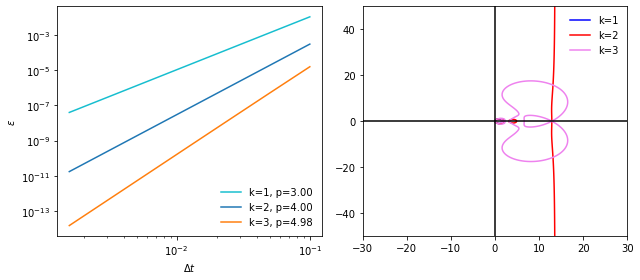

In [7]:
LMM_par_desc = {'sweeper_params': {'QI': 'LMMpar', 'num_nodes': 3}}

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
plot_orders(axs[0], ks, True, Tend_fixed=0.1, custom_description=LMM_par_desc, dt_list=0.1 * 2.**(-np.arange(7)), prob=run_piline)
stats, _, _ = run_dahlquist(custom_description=LMM_par_desc)
plot_stability(stats, ax=axs[1], iter=ks)
fig.tight_layout()

This is curious! We get a second order prediction, but then we get only first order correction sweeps.
Also, this implementation of the trapezoidal rule seems to be A stable again for multiple iterations, which is good news!